<a href="https://colab.research.google.com/github/jh941213/image_segementation/blob/main/2_UNET_%E1%84%83%E1%85%A9%E1%86%BC%E1%84%86%E1%85%AE%E1%86%AF_image_segmentation_using_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**editor:** Jintae Kim<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2023/02/02<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## 환경 설정

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies 1bPlbzsaspD58iOp4dkto2NPwdoYUN7HM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1bPlbzsaspD58iOp4dkto2NPwdoYUN7HM
To: /content/nyu_data.zip
100% 4.40G/4.40G [01:02<00:00, 70.0MB/s]


In [ ]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 5.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from IPython.display import Image, display
from PIL import ImageOps
from matplotlib import pyplot as plt

from keras_unet_collection import models, base, utils
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from tensorflow.keras.preprocessing import image
import cv2

In [ ]:
from tensorflow.python.client import device_lib
for dev in device_lib.list_local_devices():
    print(dev.device_type, dev.memory_limit)
gpu_max_mem = float(device_lib.list_local_devices()[0].memory_limit)
gpu_mem_limit = 12
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1024*1024*1024*gpu_mem_limit/gpu_max_mem)
    )
sess = tf.compat.v1.Session(config=config)

CPU 268435456
GPU 14417788928


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# https://drive.google.com/drive/folders/1LHZYj7XFCjLmxyAxTxbArGuVg31TGqeG?usp=sharing

Mounted at /content/drive


## Data 다운로드

In [ ]:
#oxford pet data
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.6M      0  0:00:55  0:00:55 --:--:-- 14.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4655k      0  0:00:04  0:00:04 --:--:-- 4655k


## 이미지 데이터 path 지정

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:3], target_img_paths[:3]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png


## 학습 데이터 파악

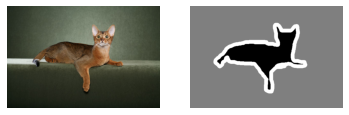

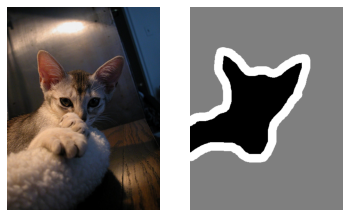

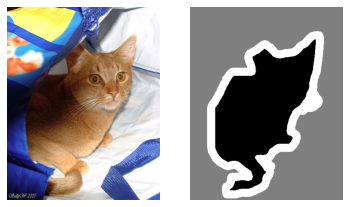

In [ ]:
for img_idx in range(3):
    ori_img = load_img(input_img_paths[img_idx])
    target_img = ImageOps.autocontrast(load_img(target_img_paths[img_idx]))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(target_img, vmax = 3, vmin = 0)
    plt.show()

## 데이터로더 구성

In [ ]:
class OxfordPetsData(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        i = idx * self.batch_size
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

            # target data에 있는 라벨인 1, 2, 3 에서 1을 빼서 0, 1, 2 로 변경
            y[j] -= 1

        # (input, target) 반환
        return x, y


## 라이브러리를 사용한 모델 구축

In [ ]:
keras.backend.clear_session()

model = models.unet_2d((None, None, 3), [64, 128, 256, 512], n_labels=3,
                      stack_num_down=2, stack_num_up=1,
                      activation='ReLU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

model = models.resunet_a_2d((128, 128, 3), [32, 64, 128, 256], 
                             dilation_num=[1, 3, 15], 
                            n_labels=3, aspp_num_down=128, aspp_num_up=64, 
                             activation='ReLU', output_activation='Sigmoid', 
                             batch_norm=True, pool=False, unpool='nearest', name='resunet')

Received dilation rates: [1, 3, 15]
Received dilation rates are not defined on a per downsampling level basis.
Automated determinations are applied with the following details:
	depth-0, dilation_rate = [1, 3, 15]
	depth-1, dilation_rate = [1, 3, 15]
	depth-2, dilation_rate = [1, 3]
	depth-3, dilation_rate = [1]


## 트레이닝 데이터 분할 및 데이터로더 생성

In [ ]:
import random

# train, val split
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPetsData(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetsData(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 학습

In [ ]:
# model = keras.models.load_model('/content/oxford_segmentation_resunet.h5')

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    # keras.callbacks.ModelCheckpoint("oxford_segmentation_resunet.h5", save_best_only=True)
]

with tf.device("/device:GPU:0"):
    model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
199/199 [==============================] - 289s 1s/step - loss: 0.6108 - val_loss: 0.5829
Epoch 2/10
 23/199 [==>...........................] - ETA: 3:43 - loss: 0.4945

KeyboardInterrupt: ignored

In [ ]:
val_preds = model.predict(val_gen)
print(len(val_preds), val_preds[0].shape)

31/31 [==============================] - 12s 322ms/step
992 (128, 128, 3)


## 결과 시각화

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2

color_map = {
 '0': [255, 0, 0],
 '1': [0, 0, 0],
 '2': [255, 255, 255],
}

def resize_mask(img, target_size):
    mask = np.argmax(img, axis=-1)
    mask = tf.expand_dims(mask, axis=-1).numpy().astype(float)
    return cv2.resize(mask, dsize=target_size, interpolation=cv2.INTER_NEAREST)

def add_mask_to_img(input_img, mask, alpha = 0.6):
    img_color = image.img_to_array(input_img)
    img = image.img_to_array(input_img)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            img_color[i, j] = color_map[str(int(mask[i, j]))]
    
    alpha = 0.6
    img = cv2.addWeighted(img, alpha, img_color, 1-alpha, 0, img_color, dtype = cv2.CV_32F)
    return img

def ero_dil(im, filter_size = 5):
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_size, filter_size))
    im = cv2.dilate(im, se) #팽창
    im = cv2.erode(im, se) #침식

    return im

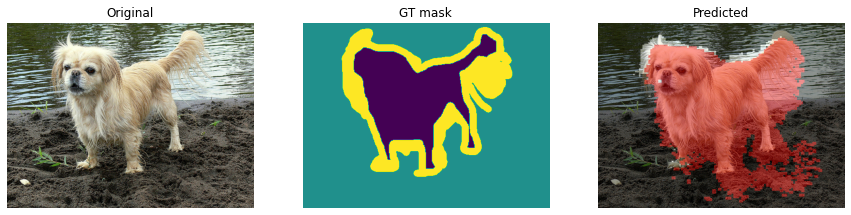

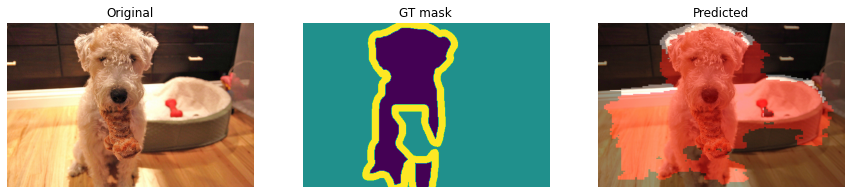

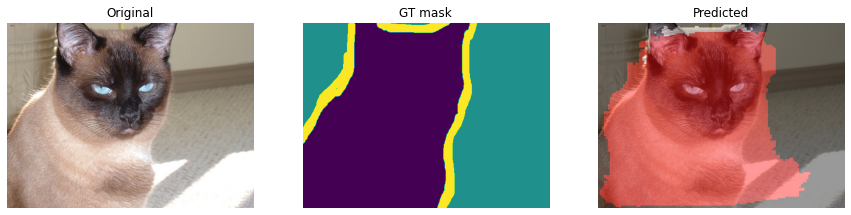

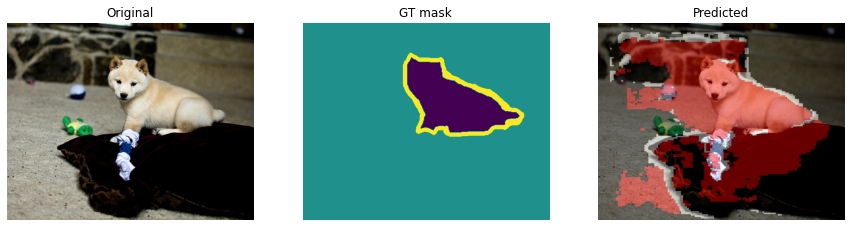

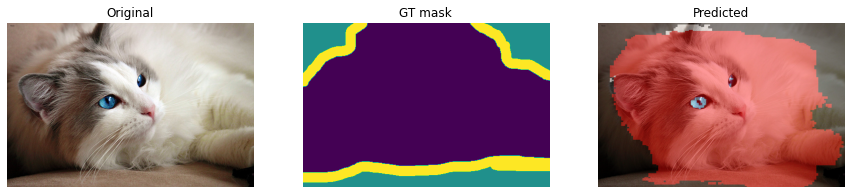

In [ ]:
for img_idx in random.sample(list(range(len(val_preds))), 5):
    plt.figure(figsize=(15,8))

    ori_img = load_img(val_input_img_paths[img_idx])
    target_img = load_img(val_target_img_paths[img_idx])
    target_mask = image.img_to_array(target_img)[:,:,0] - 1
    
    mask = val_preds[img_idx]

    plt.subplot(1,3,1)
    plt.title('Original')
    plt.axis("off")
    plt.imshow(ori_img)
    
    plt.subplot(1,3,2)
    plt.title('GT mask')
    plt.axis("off")
    plt.imshow(target_mask)

    resized_mask = resize_mask(mask, ori_img.size)
    masked_img = add_mask_to_img(ori_img, resized_mask)

    plt.subplot(1,3,3)
    plt.title('Predicted')
    plt.axis("off")
    processed_mask = ero_dil(resized_mask)
    masked_img = add_mask_to_img(ori_img, processed_mask)
    plt.imshow(image.array_to_img(masked_img))

    plt.show()